In [21]:
#####Latent Variable timestamp allocation#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [92]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) > np.random.rand(n).reshape(n, 1)), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

In [22]:
####データの発生####
##データの設定
k = 7
week = 7
hour = 24
hh = 5000
pt = np.random.poisson(np.random.gamma(20, 1/0.25, hh), hh)
hhpt = np.sum(pt)

In [23]:
##IDとインデックスの設定
#IDの設定
user_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.arange(hhpt)
user_list = [i for i in range(hh)]
user_vec = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
    user_vec[i] = np.repeat(1, pt[i])

In [25]:
##説明変数の生成
k1 = 4; k2 = 5; k3 = 6
x1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)
col = x.shape[1]

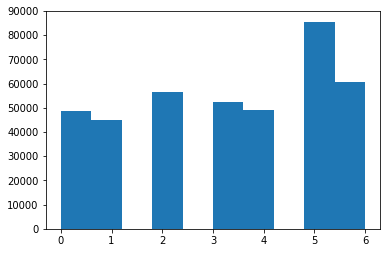

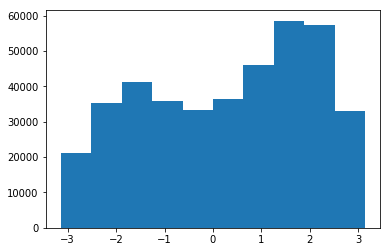

In [138]:
##応答変数を生成
#モデルパラメータを設定
theta = np.random.dirichlet(np.repeat(0.2, k), hh)
phi = np.random.dirichlet(np.repeat(0.25, week), k)
beta = np.append(np.random.uniform(-1.25, 1.75, k), np.random.normal(0, 0.75, k*(col-1))).reshape(k, col, order="F")
kappa = np.random.uniform(2.0, 7.5, k)
thetat = theta.copy(); phit = phi.copy(); betat = beta.copy(); kappat = kappa.copy()

#トピックを生成
Z = np.array(rmnom(theta[user_id, ], hhpt, k, np.arange(hhpt)).todense(), dtype="int16")
z_vec = np.dot(Z, np.arange(k))

#トピックからtimestampを生成
W = np.array(rmnom(phi[z_vec, ], hhpt, week, np.arange(hhpt)).todense(), dtype="int16")
w = np.dot(W, np.arange(week))
mu = 2*np.arctan(np.dot(x * beta[z_vec, ], np.repeat(1, col)))
y = np.random.vonmises(mu, kappa[z_vec], hhpt)
plt.hist(w); plt.show()
plt.hist(y); plt.show()

In [141]:
####EMアルゴリズムでLatent Variable timestamp allocationを推定####
##Von Mises Regression modelのパラメータを推定するための関数
#Von Mises Regression modelの対数尤度関数
def loglike(theta, y, x, N, index1, index2):
    
    #パラメータの設定
    beta = theta[index1]
    kappa = np.exp(theta[index2])
    
    #対数尤度の和を計算
    mu = 2*np.arctan(np.dot(x, beta))
    LL = -N*np.log(scipy.special.i0(kappa)) + kappa*np.sum(np.cos(y - mu))
    return -LL

In [142]:
#Von Mises Regression modelの対数尤度関数の勾配ベクトル
def dloglike(theta, y, x, N, index1, index2):
    
    #パラメータの設定
    beta = theta[index1]
    kappa = np.exp(theta[index2])

    #回帰ベクトルの対数尤度の勾配ベクトル
    beta_mu = np.dot(x, beta)
    mu = 2*np.arctan(beta_mu)
    LLd1 = np.sum(kappa * (np.sin(y - mu).reshape(N, 1)) * (2 * (x / (1 + np.power(beta_mu.reshape(N, 1), 2)))), axis=0)
    
    #分散パラメータの対数尤度の勾配
    h = 1e-4
    LLd2 = (LL_kappa(kappa+h, mu, y, x, N) - LL_kappa(kappa-h, mu, y, x, N)) / (2*h)
    
    #勾配ベクトルの戻り値
    LLd = -np.append(LLd1, LLd2)
    return LLd

In [143]:
#分散パラメータの推定用の対数尤度関数
def LL_kappa(kappa, mu, y, x, N):
    LL = -N*np.log(scipy.special.i0(kappa)) + kappa*np.sum(np.cos(y - mu))
    return LL 

In [148]:
##観測データの尤度と潜在変数zを計算する関数
def LLobz(theta, phi, beta, kappa, y, w, x, user_id, k, hhpt):
    #潜在変数の条件付き尤度
    Lho1 = np.zeros((hhpt, k))
    mu = 2*np.arctan(np.dot(x, beta.T))   #リンク関数
    for j in range(k):
        Lho1[:, j] = np.sum(np.log(np.exp(kappa[j]*np.cos(y - mu[:, j])) / (2*np.pi*scipy.special.i0(kappa[j]))))
    Lho2 = phi.T[w, ]

    #潜在変数の割当確率
    Lho = theta[user_id, ] * Lho1 * Lho2
    z = Lho / np.dot(Lho, np.repeat(1, k)).reshape(hhpt, 1)
    return z, Lho

array([0.70147314, 0.49004008, 0.06904586, ..., 0.32502195, 0.3606102 ,
       0.61910048])

[2.26457504e-02 1.95254822e-07 2.69208624e-01 6.98368760e-01
 6.72146588e-04 1.29785440e-03 7.80666896e-03]
[0 0 1 0 0 0 0]


In [196]:
Z

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [181]:
%%time
np.sum(np.log(np.exp(kappa[j]*np.cos(y - mu)) / (2*np.pi*scipy.special.i0(kappa[j]))))


Wall time: 7.98 ms


-383802.67704256944

In [184]:
.shape

(397968, 7)

In [185]:
beta

array([[ 5.98006514e-01,  1.29017883e-01, -2.23048824e-01,
        -2.56036968e+00, -1.76913342e-01,  5.48725837e-01,
        -6.95155065e-01, -1.07195310e-02,  5.51821540e-01,
         4.77658088e-01,  3.97993571e-02,  5.48410357e-01,
        -2.41985933e-01,  1.51064762e-01,  4.36373643e-01],
       [ 1.74112589e+00,  3.91850459e-01, -3.24328430e-01,
         4.07720176e-01,  1.56827853e+00, -3.61775603e-01,
        -8.07900286e-01, -3.32978393e-01, -3.50327203e-01,
         2.80490430e-01, -2.91312898e-01, -3.76429621e-01,
         1.59929323e+00, -4.36751788e-01,  5.48805736e-01],
       [ 3.40013908e-01, -2.94244156e-01, -9.35856601e-01,
        -2.55780774e-01, -1.23267010e-01, -9.73944006e-01,
         3.00225107e-01,  2.38896668e-01,  1.39170260e+00,
        -6.47088685e-01, -2.21936459e-02,  7.95358583e-02,
         3.55250760e-01, -5.01458138e-01,  6.68024967e-01],
       [ 5.91402321e-02,  2.57719251e-01, -2.92757243e-02,
         7.71775788e-04,  1.11980051e+00, -1.23446470